This is a tutorial to demonstrate using the python MAF interface to run a few metrics with a single SQL constraint + slicer.

Using the python interface to MAF can be simpler than using the full driver script + configuration files in the case of a user who wants to use a few metrics or a few sql constraints. Let's focus on the use case example of: <br>
*"I am an opsim user who wants to understand the distribution of sky position angles (rotSkyPos in the opsim output tables) in an opsim run".*

Requirements: the user has sims_maf installed (see [installation instructions](https://confluence.lsstcorp.org/display/SIM/Catalogs+and+MAF)) and setup (see [setup instructions](https://confluence.lsstcorp.org/display/SIM/MAF+Installation+and+Initial+Examples#MAFInstallationandInitialExamples-runningexamples)).  

Let's load all of the MAF modules we'll need. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.sliceMetrics as sliceMetrics
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils

---
For users new to MAF: The first thing is to break down the question of *"understand the distribution of rotSkyPos in opsim"* into more specific chunks. What do we want to measure, and over what subset of visits do we want to calculate those measurements? In MAF these map to specific "[metrics](https://confluence.lsstcorp.org/display/SIM/MAF+Metrics)" (how to calculate what we want to measure) and "[slicers](https://confluence.lsstcorp.org/display/SIM/MAF+Slicers)" (how to subdivide the opsim visits).

__Pick a slicer:__ It can be helpful to first choose the slicer. This is equivalent to saying what subset of visits we want to combine when we are making the metric measurement. If you wanted to take the mean of the airmass, for example, the slicer would determine whether you calculated the mean airmass 'of all visits' or 'of all visits which overlap a particular RA/Dec point' (resulting in a grid of mean airmass values across the sky). 

In this case, to *understand the distribution of rotSkyPos in opsim"* we probably want to look at some measurements of the rotSkyPos distribution at a grid of points across the sky. The most useful slicers will then be the `HealpixSlicer` (which means we'd evaluate the metrics at each point in a healpix grid across the sky) or an `OpsimFieldSlicer` (which means we'd evaluate the metrics at the centers of the opsim field pointings, a fixed tesselation on the sky). 

So let's choose the `HealpixSlicer`, which will let the user specify the resolution to evaluate the metrics. Now our use case is becoming *understand the distribution of rotSkyPos at each point in a healpix grid across the sky*.

In [2]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


__Pick the metrics.__ Let's now think about what we want to measure about the rotSkyPos values at each opsim pointing. A good mix seems: mean, rms and full range (max-min), which are available as simple metrics within MAF.  Let's create these as a list just to make it easier to cart around later.  

When we use these simple metrics, we just instantiate the classes and determine what column/value of Opsim data per visit we want to evaluate -- here, for example, we want to evaluate the mean of the rotSkyPos values (for each subset of visits which overlap each of the healpix grid points). 

Now our use case example is *measure the mean, RMS, and (max-min) values of the rotSkyPos at each point in a healpix grid across the sky*. 

In [3]:
metriclist = []
metriclist.append(metrics.MeanMetric('rotSkyPos'))
metriclist.append(metrics.RmsMetric('rotSkyPos'))
metriclist.append(metrics.FullRangeMetric('rotSkyPos'))

__Add these to a RunSliceMetric.__ We use these to get a "RunSliceMetric" set up. A RunSliceMetric object combines a slicer and metrics, and provides convenience methods to calculate, store, save and visualize the metric data. 

In [4]:
outDir = 'rotSkyPos_Test'
sm = sliceMetrics.RunSliceMetric(outDir=outDir)
sm.setMetricsSlicerStackers(metriclist, slicer)

__Connect to an opsim sqlite database.__  Some opsim databases are available [here](https://confluence.lsstcorp.org/display/SIM/OpSim+Datasets+for+Cadence+Workshop+LSST2015).

In [5]:
runName = 'enigma_1189'
opsdb = db.OpsimDatabase('sqlite:///' + runName + '_sqlite.db')

MAF provides convenience methods + built-in framework utilities to identify what data you need from the database (and what could be added 'on-the-fly' using [stackers](https://confluence.lsstcorp.org/display/SIM/MAF+Stackers)).  We'll now use one of those methods to easily get a list of the columns we'd need from the database (Hint: these columns are 'rotSkyPos', obviously, and 'fieldRA', 'fieldDec' so that the slicer can work and create plots). 

Note that if stackers are necessary for a particular column required anywhere (e.g. if you were calculating MeanMetric on HA, which is not a standard part of the opsim output table), they will automatically be added to the RunSliceMetric. However, users can configure stackers and add them manually, if desired. These are nice additional conveniences of the framework, although we're not using that here. (see the [HA](Hour%20Angle%20MAF%20example.ipynb) tutorial for an example including stackers). 

In [6]:
dbcols = sm.findDataCols()
print dbcols

set(['fieldDec', 'fieldRA', 'rotSkyPos'])


__Get the opsim data.__ We'll just look at r band visits. 

In [7]:
sqlconstraint = '%s' %("filter = 'r'")
simdata = utils.getSimData(opsdb, sqlconstraint, dbcols, sm.stackerObjs)
print simdata.dtype.names

('obsHistID', 'fieldDec', 'fieldRA', 'rotSkyPos')


__Calculate the metric values.__ We can also pass in the runName, sqlconstraint and 'metadata' (to help label plots/identify more information in the output files, etc.). 

In [8]:
sm.runSlices(simdata, simDataName=runName, sqlconstraint=sqlconstraint, metadata='r band')

__Save the metric results to disk.__ (we can read this back later). 

In [9]:
sm.writeAll()

What files were written? 

In [10]:
!ls $outDir

enigma_1189_FullRange_rotSkyPos_r_band_HEAL.npz enigma_1189_Rms_rotSkyPos_r_band_HEAL.npz
enigma_1189_Mean_rotSkyPos_r_band_HEAL.npz      resultsDb_sqlite.db


The .npz files are the metric data files written by MAF. '.npz' is a numpy file format that roughly corresponds to a dictionary. They can be easily read back into MAF via a sliceMetric 'readMetricData' call.  MAF can also write the results as JSON files if needed. 

__Visualize the results.__ Let's make plots. This also saves the plots to disk.

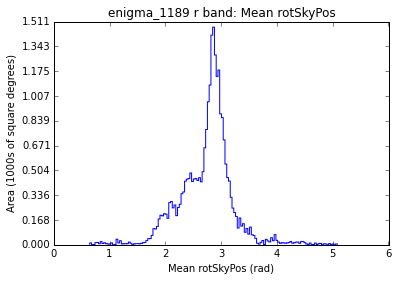

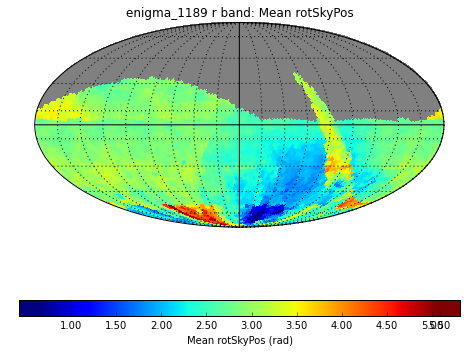

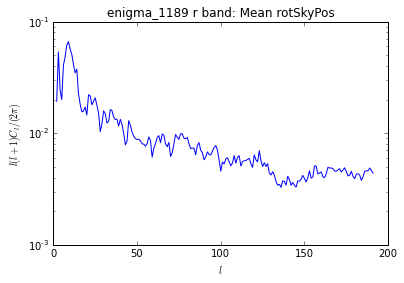

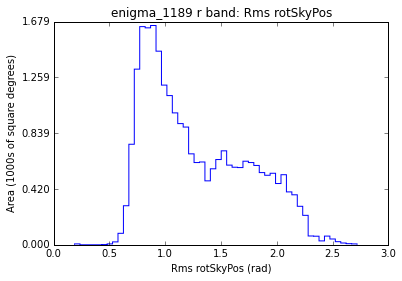

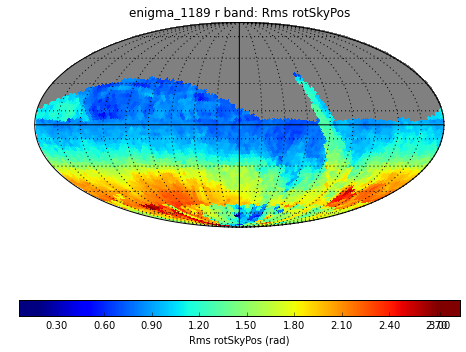

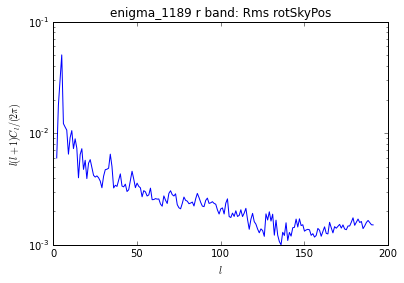

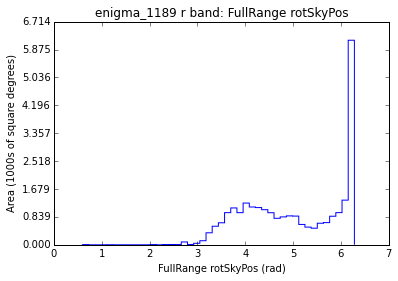

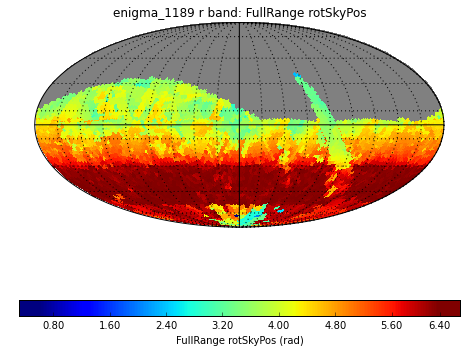

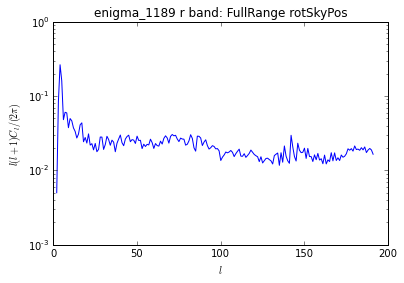

In [11]:
sm.plotAll()

Suppose we want to look more closely at the sky plot for the RMS calculations. How do we investigate these? The metric values (and associated metadata for each metric) are stored in the sliceMetric, in dictionaries keyed by an integer id.  The metric values themselves are saved in numpy masked arrays, in a similar dictionary. 

In [12]:
for iid in sm.metricNames:
    print iid, sm.metricNames[iid], sm.metricValues[iid][-1], sm.metricValues[iid].compressed().mean()

0 Mean rotSkyPos 2.84326456667 2.74452613624
1 Rms rotSkyPos 1.11646654361 1.28625622752
2 FullRange rotSkyPos 3.310179 5.02149518106


We can alter the plots by changing the [plotDict](https://confluence.lsstcorp.org/display/SIM/MAF+Metrics#MAFMetrics-PlotParameterKeywords) associated with a particular metric id: 

In [13]:
iid = 1
print sm.plotDicts[iid]

{'units': 'rad', 'xlabel': 'Rms rotSkyPos (rad)', 'title': 'enigma_1189 r band: Rms rotSkyPos'}


{'Histogram': 1, 'PowerSpectrum': 3, 'SkyMap': 2}

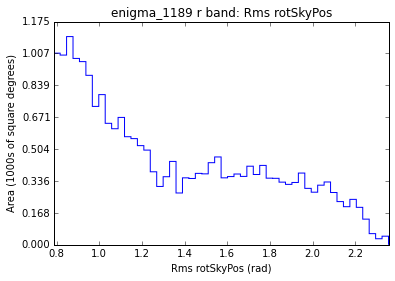

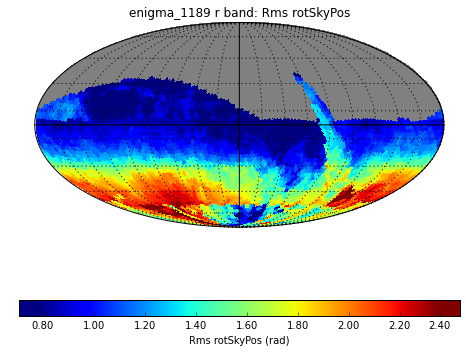

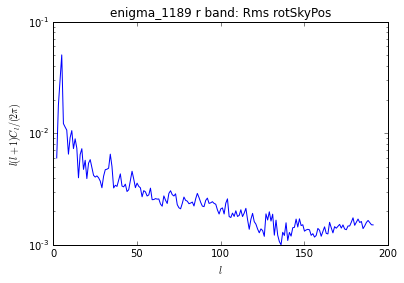

In [14]:
sm.plotDicts[iid]['colorMin'] = np.radians(45)
sm.plotDicts[iid]['colorMax'] = np.radians(135)
sm.plotDicts[iid]['xMin'] = np.radians(45)
sm.plotDicts[iid]['xMax'] = np.radians(135)
sm.plotMetric(iid)

__Calculate 'summary statistics'.__ Often, after calculating these values at each point across the sky, we also want some single-value statistics to summarize the results. Pretty often, for example, we'd want the median and mean of the metric values, perhaps also the rms. 

To do this, we instantiate some new metrics that we'll apply to the metric values, thus will operate on 'metricdata' as the column. The results are returned (here printed to screen) and also saved into the sqlite file 'resultsDB_sqlite.db'. 

In [15]:
summaryStats = []
summaryStats.append(metrics.MeanMetric('metricdata'))
summaryStats.append(metrics.MedianMetric('metricdata'))
summaryStats.append(metrics.RmsMetric('metricdata'))

for iid in sm.metricValues:
    for stat in summaryStats:
        val = sm.computeSummaryStatistics(iid, stat)
        print sm.metricNames[iid], '\t', stat.name, '\t', val

Mean rotSkyPos 	Mean metricdata 	[2.7445261362415985]
Mean rotSkyPos 	Median metricdata 	[2.8191296455991512]
Mean rotSkyPos 	Rms metricdata 	[0.46914715475518737]
Rms rotSkyPos 	Mean metricdata 	[1.286256227518094]
Rms rotSkyPos 	Median metricdata 	[1.1592344729496484]
Rms rotSkyPos 	Rms metricdata 	[0.46109597828296428]
FullRange rotSkyPos 	Mean metricdata 	[5.0214951810644051]
FullRange rotSkyPos 	Median metricdata 	[5.0032579999999998]
FullRange rotSkyPos 	Rms metricdata 	[1.0103786963993857]


Here's a look inside the results database, so we can see what's preserved there. 

In [16]:
sqlcommand = 'select metrics.metricId, metricName, slicerName, metricMetadata, summaryName, summaryValue '
sqlcommand += 'from metrics, summaryStats where metrics.metricId = summaryStats.metricId'
!sqlite3 $outDir'/resultsDb_sqlite.db' '$sqlcommand'

1|Mean rotSkyPos|HealpixSlicer|r band|Mean|2.7445261362416
1|Mean rotSkyPos|HealpixSlicer|r band|Median|2.81912964559915
1|Mean rotSkyPos|HealpixSlicer|r band|Rms|0.469147154755187
2|Rms rotSkyPos|HealpixSlicer|r band|Mean|1.28625622751809
2|Rms rotSkyPos|HealpixSlicer|r band|Median|1.15923447294965
2|Rms rotSkyPos|HealpixSlicer|r band|Rms|0.461095978282964
3|FullRange rotSkyPos|HealpixSlicer|r band|Mean|5.02149518106441
3|FullRange rotSkyPos|HealpixSlicer|r band|Median|5.003258
3|FullRange rotSkyPos|HealpixSlicer|r band|Rms|1.01037869639939


The full outputs of this particular set of metrics, run with the healpix slicer, includes the metric values (the .npz files), the plots (saved as PDF together with PNG thumbnails by default), and the summary statistics (saved in the resultsDB_sqlite.db sqlite database). 

In [17]:
!ls $outDir

enigma_1189_FullRange_rotSkyPos_r_band_HEAL.npz                     enigma_1189_Rms_rotSkyPos_r_band_HEAL_SkyMap.pdf
enigma_1189_FullRange_rotSkyPos_r_band_HEAL_Histogram.pdf           resultsDb_sqlite.db
enigma_1189_FullRange_rotSkyPos_r_band_HEAL_PowerSpectrum.pdf       thumb.enigma_1189_FullRange_rotSkyPos_r_band_HEAL_Histogram.png
enigma_1189_FullRange_rotSkyPos_r_band_HEAL_SkyMap.pdf              thumb.enigma_1189_FullRange_rotSkyPos_r_band_HEAL_PowerSpectrum.png
enigma_1189_Mean_rotSkyPos_r_band_HEAL.npz                          thumb.enigma_1189_FullRange_rotSkyPos_r_band_HEAL_SkyMap.png
enigma_1189_Mean_rotSkyPos_r_band_HEAL_Histogram.pdf                thumb.enigma_1189_Mean_rotSkyPos_r_band_HEAL_Histogram.png
enigma_1189_Mean_rotSkyPos_r_band_HEAL_PowerSpectrum.pdf            thumb.enigma_1189_Mean_rotSkyPos_r_band_HEAL_PowerSpectrum.png
enigma_1189_Mean_rotSkyPos_r_band_HEAL_SkyMap.pdf                   thumb.enigma_1189_Mean_rotSkyPos_r_band_HEAL_SkyMap.png
enigma_1189_Rms_

You can investigate the plots or metrics further individually, or look at all at once via the 'showMaf.py' script.  (note that it's cleaner to start this directly from a shell prompt - and you can have multiple runs in the same MAF output directories!). To add more information on the opsim run itself, it is also nice to grab the opsim configuration info before adding the directory to the showMaf.py tracking database. 

In [19]:
configSummary, configDetails = opsdb.fetchConfig()
outfile = os.path.join(outDir, 'configSummary.txt')
f = open(outfile, 'w')
utils.printDict(configSummary, 'Summary', f)
f.close()
outfile = os.path.join(outDir, 'configDetails.txt')
f = open(outfile, 'w')
utils.printDict(configDetails, 'Details', f)
f.close()
!showMaf.py -d $outDir -p 8080

Using tracking database at sqlite:////Users/lynnej/otherRepos/LSST-Tutorials/MAF/trackingDb_sqlite.db
Adding to tracking database at sqlite:////Users/lynnej/otherRepos/LSST-Tutorials/MAF/trackingDb_sqlite.db:
 MafDir = /Users/lynnej/otherRepos/LSST-Tutorials/MAF/rotSkyPos_Test
 MafComment = None
 OpsimRun = enigma_1189
 OpsimComment = 1/2 NES w/proper DD #s potential reference
 OpsimDate = 03/18/15
 MafDate = 04/19/15
 Used runID 1
Tornado Starting: 
Point your web browser to http://localhost:8080/ 
Ctrl-C to stop
